# Kaggle Competition - Digit Recognizer
In this notebook we'll train a neural network to detect handwritten digits in images using Pytorch.

[Competition on Kaggle](https://www.kaggle.com/c/digit-recognizer)

## Competition Description
* __Objective__: Identify handwritten digits in a given (test-)dataset of images.
* __Problem Frame__: Supervised, offline, multi-class classification problem.
* __Performance Metric__: Categorization accuracy of the predictions.
* __Data__: [Kaggle MNIST Dataset](https://www.kaggle.com/c/digit-recognizer/data), labels are integers from 0 to 9, all images have the size (28, 28) and have been unrolled into 1d arrays.

## Magics & Imports

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
torch.cuda.current_device()

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import datasets, transforms, utils
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report

# Make direct importing of mltools modules work:
import sys
sys.path.append('..')

from mltools.dirtools import show_dir_contents
from mltools.classification.datasets import CSVImageDataset, DataframeImageDataset
from mltools.classification.utils import train, predict, predict_with_augmentations
from mltools.io import save_run, load_run

from tqdm.auto import tqdm

## Get the Data
The training and test sets are specified by two .csv files which are provided in the competition's data.
At first, we'll use a part of the training set to create a validation set. For the actual submission we'll later
train using the full training set.

In [3]:
# We'll assume that the data has been downloaded to a 'local_data'-folder:
data_path = Path('../local_data/mnist_kaggle/')

In [4]:
show_dir_contents(data_path)

Contents of '..\local_data\mnist_kaggle':

Name                      Length (kB)
----                      -----------
runs
model.pkt                 411
sample_submission.csv     235
test.csv                  49920
train.csv                 74976


### Define Data Transforms
We will normalize and transform all sample images to Pytorch tensors. For the training dataset,
we apply some mild data augmentations, including rotation, scaling and translation.

In [5]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=3, scale=(0.95, 1.05), translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = val_transform

transforms_dict = {'train': train_transform, 'val': val_transform, 'test': test_transform}

### Create Datasets
We use custom Datasets from `mltools.classfication.datasets` (which all subclass `torch.Dataset`)
to hold our data. As the labels are integers ranging from 0 to 9 and pixel values range from 0 to 255, it is enough to use 8 bit unsigned integers to
store the data.

In [6]:
def get_datasets(data_path, transforms_dict):
    df_train_val = pd.read_csv(data_path / 'train.csv')
    df_train, df_val = train_test_split(df_train_val, test_size=0.1, stratify=df_train_val.iloc[:, 0:1])
    
    df_type = np.uint8
    
    train_dataset = DataframeImageDataset(df_train, (28, 28), transform=transforms_dict['train'], as_type=df_type)
    val_dataset = DataframeImageDataset(df_val, (28, 28), transforms_dict['val'], as_type=df_type)
    test_dataset = CSVImageDataset(data_path / 'test.csv', (28, 28), transforms_dict['test'], train=False, as_type=df_type)
    
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = get_datasets(data_path, transforms_dict)

In [8]:
print("Training Dataset:")
train_dataset.data_frame.info()
print("\nValidation Dataset:")
val_dataset.data_frame.info()
print("\nTest Dataset:")
test_dataset.data_frame.info()

Training Dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37800 entries, 10637 to 11066
Columns: 785 entries, label to pixel783
dtypes: uint8(785)
memory usage: 28.6 MB

Validation Dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200 entries, 39172 to 9749
Columns: 785 entries, label to pixel783
dtypes: uint8(785)
memory usage: 3.2 MB

Test Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: uint8(784)
memory usage: 20.9 MB


Here 'Density' is the ratio of non-zero values in the respective DataFrame. We can see that for all DataFrames, only about 20% of the data is non-zero, meaning that we can save a lot of memory by saving the data in a sparse DataFrames.
Note also that we stratified the samples according to their label. This
ensures that the distributions of the sample-labels in the training and validation datasets are similar. The following plots show the distributions:

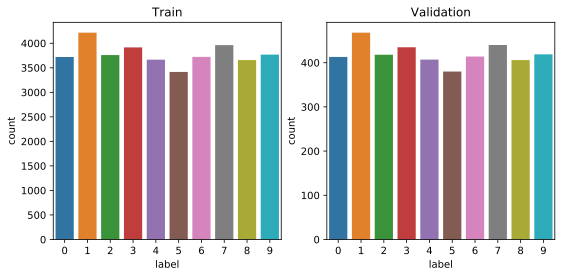

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))

sns.countplot(train_dataset.data_frame["label"], ax=ax[0])
ax[0].set_title("Train")
sns.countplot(val_dataset.data_frame["label"], ax=ax[1])
ax[1].set_title("Validation")
plt.show()

Indeed, the distributions of the label-counts are the same.

### Define Dataloaders
Pytorch Dataloaders are responsible for the batching and - if requested - the shuffling of the samples.

In [10]:
def get_data_loaders(train_ds, val_ds, test_ds, batch_size=64):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [11]:
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset)

## Explore the Data
Next we'll take a look at some sample-images.

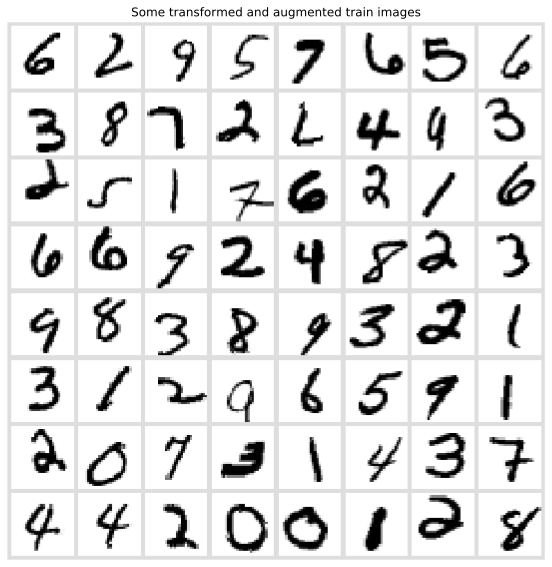

In [12]:
grid = utils.make_grid(iter(train_loader).next()[0])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(grid.numpy().transpose((1, 2, 0))[:,:,0], cmap='gray_r')
ax.axis('off')
ax.set_title('Some transformed and augmented train images')
plt.tight_layout()

## Define the Neural Network Model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
class ConvLayer(nn.Module):
    def __init__(self, n_in, n_out, ks=3, pd=0):
        super().__init__()
        self.layer = nn.Conv2d(n_in, n_out, kernel_size=ks, padding=pd)

    def forward(self, X):
        return F.relu(self.layer(X))
    
class Flatten(nn.Module):
    def forward(self, X):
        return X.view(X.size(0), -1)

In [15]:
def weight_init(m):
    if isinstance(m, ConvLayer):
        nn.init.xavier_normal_(m.layer.weight)

In [16]:
def get_model():
    net = nn.Sequential(
        ConvLayer(1, 32, ks=7, pd=3),
        nn.BatchNorm2d(32),
        ConvLayer(32, 32, ks=5, pd=2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
        nn.Dropout2d(0.25),
        ConvLayer(32, 64),
        nn.BatchNorm2d(64),
        ConvLayer(64, 64),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, stride=2),
        nn.Dropout2d(0.25),
        nn.AdaptiveMaxPool2d(1),
        Flatten(),
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),
        nn.Linear(256, 10),
        nn.LogSoftmax(-1)
    ).to(device)
    
    net.apply(weight_init)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, min_lr=1e-5)
    return net, criterion, optimizer, scheduler

In [17]:
net, criterion, optimizer, scheduler = get_model()

In [18]:
net

Sequential(
  (0): ConvLayer(
    (layer): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ConvLayer(
    (layer): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout2d(p=0.25)
  (6): ConvLayer(
    (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ConvLayer(
    (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout2d(p=0.25)
  (12): AdaptiveMaxPool2d(output_size=1)
  (13): Flat

## Train the Network

In [19]:
results = train(net, 
                num_epochs=15, 
                train_dl=train_loader, 
                optimizer=optimizer, 
                scheduler=scheduler,
                criterion=criterion,
                test_dl=val_loader,
                device=device
               )

Epoch 0: Train: loss: 0.006725, accuracy: 0.8604, Test: loss: 0.001476, accuracy: 0.9698


Epoch 1: Train: loss: 0.002160, accuracy: 0.9581, Test: loss: 0.000924, accuracy: 0.9831


Epoch 2: Train: loss: 0.001802, accuracy: 0.9648, Test: loss: 0.000860, accuracy: 0.9840


Epoch 3: Train: loss: 0.001577, accuracy: 0.9708, Test: loss: 0.000808, accuracy: 0.9869


Epoch 4: Train: loss: 0.001404, accuracy: 0.9739, Test: loss: 0.000769, accuracy: 0.9876


Epoch 5: Train: loss: 0.001503, accuracy: 0.9716, Test: loss: 0.000730, accuracy: 0.9881


Epoch 6: Train: loss: 0.001335, accuracy: 0.9746, Test: loss: 0.000480, accuracy: 0.9929


Epoch 7: Train: loss: 0.001199, accuracy: 0.9775, Test: loss: 0.000773, accuracy: 0.9883


Epoch 8: Train: loss: 0.001141, accuracy: 0.9785, Test: loss: 0.000598, accuracy: 0.9888


Epoch 9: Train: loss: 0.001095, accuracy: 0.9797, Test: loss: 0.000486, accuracy: 0.9919


Epoch 10: Train: loss: 0.001123, accuracy: 0.9793, Test: loss: 0.000758, accuracy: 0.9890


Epoch 11: Train: loss: 0.001035, accuracy: 0.9812, Test: loss: 0.000533, accuracy: 0.9893


Epoch 12: Train: loss: 0.001032, accuracy: 0.9814, Test: loss: 0.000690, accuracy: 0.9910


Epoch 13: Train: loss: 0.000976, accuracy: 0.9817, Test: loss: 0.000597, accuracy: 0.9898


Epoch 14: Train: loss: 0.000686, accuracy: 0.9865, Test: loss: 0.000456, accuracy: 0.9933

Finished Training!


### Save the Model and Data for this Run

In [ ]:
saved_run_path = save_run(model=net, runs_dir=data_path / "runs", data={"train": train_dataset, "val": val_dataset, "test": test_dataset})

## Examine Results

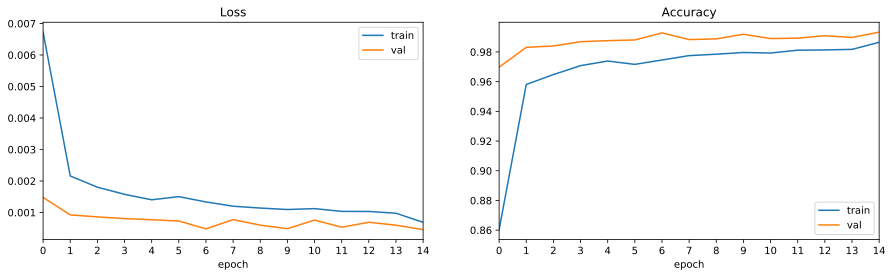

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

results.train_loss.plot(label="train", ax=ax[0])
results.test_loss.plot(label="val", ax=ax[0])
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xticks(results.index)

results.train_accuracy.plot(label="train", ax=ax[1])
results.test_accuracy.plot(label="val", ax=ax[1])
ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_xticks(results.index)

plt.show()

*Note*: The model achieves lower losses and higher accuracies for the validation dataset when compared to those of the training dataset. The reason for this might be a combination of not using
data-augmentations or Dropout when calculating the predictions on the validation dataset. 

### Calculate Predictions for the Validation Dataset

#### (Optional) Load saved Model and Data

In [25]:
net, data = load_run(model=get_model()[0], run_path=saved_run_path)
train_dataset = data["train"]
val_dataset = data["val"]
test_dataset = data["test"]

train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset)

Successfully loaded model data from model.pkt
Successfully loaded data from data.pkl


#### Make Predictions

In [22]:
val_prediction = predict(net, val_loader)

#### Classification Report

In [23]:
print(classification_report(val_dataset.data_frame.label, val_prediction, digits=4))

              precision    recall  f1-score   support

           0     0.9976    0.9952    0.9964       413
           1     0.9936    0.9979    0.9957       468
           2     0.9976    0.9904    0.9940       418
           3     0.9954    0.9908    0.9931       435
           4     1.0000    0.9975    0.9988       407
           5     0.9974    0.9921    0.9947       380
           6     0.9928    0.9952    0.9940       414
           7     0.9865    0.9932    0.9898       440
           8     0.9853    0.9901    0.9877       406
           9     0.9881    0.9905    0.9893       419

    accuracy                         0.9933      4200
   macro avg     0.9934    0.9933    0.9933      4200
weighted avg     0.9934    0.9933    0.9933      4200



#### Confusion Matrix

In [34]:
def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    
    def off_diagonal_max(m):
        mask = np.ones(m.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        return np.max(m[mask])
    
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm.T, square=True, vmax=off_diagonal_max(cm) + 10, cmap="YlGnBu", annot=True, fmt='d', cbar=False, linewidths=2, ax=ax)
    plt.xlabel("ground truth")
    plt.ylabel("prediction")
    plt.show()

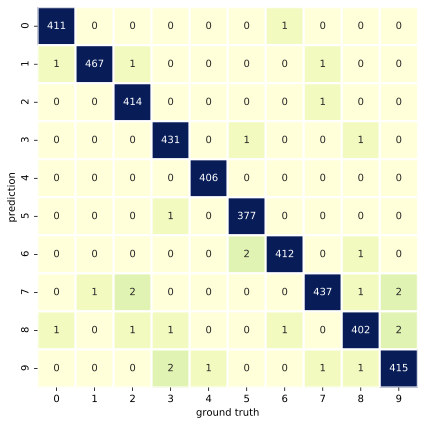

In [35]:
plot_confusion_matrix(val_dataset.data_frame.label, val_prediction)

*Note*: The model does a very good job at predicting the digits in the samples of the validation dataset. Still it is worth taking a look at some incorrectly classified images.

In [26]:
def show_incorrectly_classified_samples(df, pred, label, max_cols=5):
    combined_df = df.assign(pred=pred)
    combined_df = combined_df.reindex(columns=["pred"] + list(combined_df.columns[:-1]))
    incorrect_samples_df = combined_df[(combined_df.label == label) & (combined_df.label != combined_df.pred)]
    
    if len(incorrect_samples_df) == 0:
        print(f"No incorrect classifications of label '{label}'.\n")
    else:
        cols = min(max_cols, len(incorrect_samples_df))
        fig, ax = plt.subplots(ncols=cols, figsize=(cols, 1))
        
        print(f"Mis-classified samples with actual label {label}:")
        
        if cols == 1:
            ax.imshow(Image.fromarray(incorrect_samples_df.iloc[0, 2:].values.astype("uint8").reshape((28, 28))), cmap='gray_r')
            ax.axis("off")
            ax.set_title(f"pred: {incorrect_samples_df.iloc[0].pred}", fontsize=8, pad=0)
        else:
            for i in range(cols):
                ax[i].imshow(Image.fromarray(incorrect_samples_df.iloc[i, 2:].values.astype("uint8").reshape((28, 28))), cmap='gray_r')
                ax[i].axis("off")
                ax[i].set_title(f"pred: {incorrect_samples_df.iloc[i].pred}", fontsize=8, pad=0)
        plt.show()

Mis-classified samples with actual label 0:


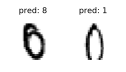

Mis-classified samples with actual label 1:


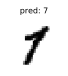

Mis-classified samples with actual label 2:


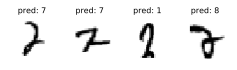

Mis-classified samples with actual label 3:


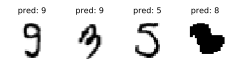

Mis-classified samples with actual label 4:


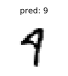

Mis-classified samples with actual label 5:


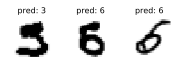

Mis-classified samples with actual label 6:


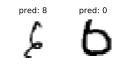

Mis-classified samples with actual label 7:


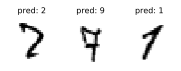

Mis-classified samples with actual label 8:


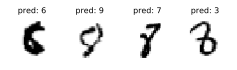

Mis-classified samples with actual label 9:


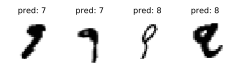

In [27]:
for i in range(10):
    show_incorrectly_classified_samples(val_dataset.data_frame, val_prediction, i, max_cols=8)

*Note*: We can see that some of the handwritten digits in these mis-classified samples are very crudely drawn and are hard to classify even for humans or seem to be mis-labeled. 

Finally, we'll train once on the full training set and create the submission file.

## Train using Full Training Dataset

In [59]:
full_train_dataset = CSVImageDataset(data_path / 'train.csv', (28, 28), transform=transforms_dict['train'])

In [60]:
full_train_dl = DataLoader(full_train_dataset, batch_size=128, shuffle=True, num_workers=0)

In [61]:
net, criterion, optimizer, scheduler = get_model()

In [62]:
full_train_results = train(
    model=net, 
    num_epochs=15, 
    train_dl=full_train_dl, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    criterion=criterion
)

Epoch 0: Train: loss: 0.003437, accuracy: 0.8556


Epoch 1: Train: loss: 0.001041, accuracy: 0.9608


Epoch 2: Train: loss: 0.000772, accuracy: 0.9706


Epoch 3: Train: loss: 0.000676, accuracy: 0.9742


Epoch 4: Train: loss: 0.000566, accuracy: 0.9790


Epoch 5: Train: loss: 0.000585, accuracy: 0.9777


Epoch 6: Train: loss: 0.000517, accuracy: 0.9804


Epoch 7: Train: loss: 0.000481, accuracy: 0.9817


Epoch 8: Train: loss: 0.000431, accuracy: 0.9840


Epoch 9: Train: loss: 0.000423, accuracy: 0.9841


Epoch 10: Train: loss: 0.000449, accuracy: 0.9834


Epoch 11: Train: loss: 0.000420, accuracy: 0.9845


Epoch 12: Train: loss: 0.000334, accuracy: 0.9876


Epoch 13: Train: loss: 0.000260, accuracy: 0.9903


Epoch 14: Train: loss: 0.000251, accuracy: 0.9907

Finished Training!


In [ ]:
save_run(net, data_path / "runs", data=full_train_dataset)

### Calculate Test Dataset Predictions

In [64]:
test_predictions = predict(net, test_loader)

In [66]:
df = pd.DataFrame(data=test_predictions, index=range(1, len(test_predictions) + 1), columns=['Label'])
df['ImageId'] = df.index
df = df[['ImageId', 'Label']]

In [67]:
df.head()

,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,0
5,5,3


### Save Submission File

In [71]:
df.to_csv(data_path / 'sub_file.csv', index=False)